In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Checking if I'm using the GPU for the computations

In [3]:
import warnings
warnings.filterwarnings("ignore")

import torch

print('Id of the currently used device: ', torch.cuda.current_device())
print('Name of the currently used device: ', torch.cuda.get_device_name(0))
print('Number of available devices (CPU, GPU): ', torch.cuda.device_count())
print('Check if cuda is available: ', torch.cuda.is_available())

Id of the currently used device:  0
Name of the currently used device:  GeForce GTX 980M
Number of available devices (CPU, GPU):  1
Check if cuda is available:  True


First thing to do is to set a proper batch size for the models I'm going to train, this is dependant on the compute power of my GPU card (8 Giga)

In [4]:
batch_size = 64

In [5]:
path_to_data = Path('../../data/motoTest/')
path_to_data.ls()

[PosixPath('../../data/motoTest/vent'),
 PosixPath('../../data/motoTest/headbanger'),
 PosixPath('../../data/motoTest/vertigo'),
 PosixPath('../../data/motoTest/askoll'),
 PosixPath('../../data/motoTest/mbk'),
 PosixPath('../../data/motoTest/betamotor'),
 PosixPath('../../data/motoTest/cpi-moto'),
 PosixPath('../../data/motoTest/vor'),
 PosixPath('../../data/motoTest/scorpa'),
 PosixPath('../../data/motoTest/bucci-moto'),
 PosixPath('../../data/motoTest/motom'),
 PosixPath('../../data/motoTest/pgo'),
 PosixPath('../../data/motoTest/valenti-racing'),
 PosixPath('../../data/motoTest/ohvale'),
 PosixPath('../../data/motoTest/leonart'),
 PosixPath('../../data/motoTest/atala'),
 PosixPath('../../data/motoTest/piaggio'),
 PosixPath('../../data/motoTest/zero'),
 PosixPath('../../data/motoTest/mondial'),
 PosixPath('../../data/motoTest/senke'),
 PosixPath('../../data/motoTest/suzuki'),
 PosixPath('../../data/motoTest/can-am-brp'),
 PosixPath('../../data/motoTest/norton'),
 PosixPath('../../dat

My dataset is in a bit of a weird format. For each motorcycle model I have folders with possible submodels and years of production. That series of folders create the final class. I will need to create a function to extract that class name.

In [6]:
file_names = get_image_files(path_to_data,recurse=True)
file_names[:5]

[PosixPath('../../data/motoTest/vent/baja-50/2013 - 19/72290.jpg'),
 PosixPath('../../data/motoTest/vent/baja-50/2013 - 19/72296.jpg'),
 PosixPath('../../data/motoTest/vent/baja-50/2013 - 19/72293.jpg'),
 PosixPath('../../data/motoTest/vent/baja-50/2013 - 19/72294.jpg'),
 PosixPath('../../data/motoTest/vent/baja-50/2013 - 19/72291.jpg')]

In [7]:
f = lambda x: '_'.join(str(x).split('/')[4:-1])

In [8]:
img_counter = {}
for img in file_names:
    img_name = f(img)
    if img_name in img_counter:
        img_counter[img_name]+=1
    else:
        img_counter[img_name]=1

In [9]:
sorted_img_counter = sorted(img_counter.items(), key=lambda x : x[1], reverse=True)
selected_classes = []
for name,count in sorted_img_counter:
    if count>100:
        selected_classes.append(name)

In [10]:
selected_file_names = [img_name for img_name in file_names if f(str(img_name)) in selected_classes]

In [11]:
selected_file_names[:5]

[PosixPath('../../data/motoTest/piaggio/mp3/2010 - 11/55965.jpg'),
 PosixPath('../../data/motoTest/piaggio/mp3/2010 - 11/56233.jpg'),
 PosixPath('../../data/motoTest/piaggio/mp3/2010 - 11/55960.jpg'),
 PosixPath('../../data/motoTest/piaggio/mp3/2010 - 11/55968.jpg'),
 PosixPath('../../data/motoTest/piaggio/mp3/2010 - 11/55966.jpg')]

In [12]:
transformations = get_transforms()
transformations

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [13]:
transformations[0].pop(3)
transformations[0].pop(3)

RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)

In [14]:
data = ImageDataBunch.from_name_func(path_to_data,selected_file_names,label_func=f, ds_tfms=transformations, size=224, bs=batch_size
                                  ).normalize(imagenet_stats)

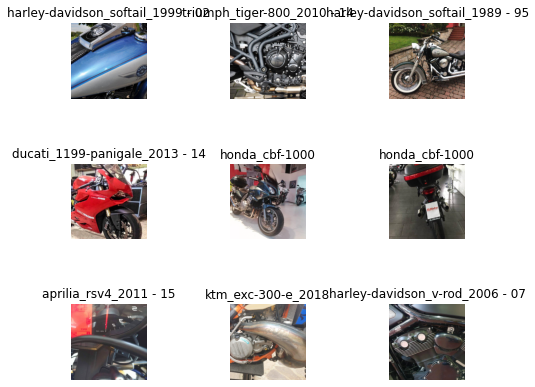

In [15]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes);
print(len(data.classes))

['aprilia_rsv4_2009 - 12', 'aprilia_rsv4_2011 - 15', 'bmw_k-100-rs', 'bmw_k-1100-rs', 'bmw_k-75-s', 'bmw_r-1100-gs', 'bmw_r-1100-rs', 'bmw_r-1100-s', 'bmw_r-1150-gs', 'bmw_r-1200-c', 'bmw_r-1200-r_2017 - 18', 'bmw_r-nine-t_2017 - 19', 'ducati_1199-panigale_2013 - 14', 'ducati_749_2003 - 07', 'ducati_diavel-1200_2010 - 13', 'ducati_hypermotard-1100-evo_2010 - 12', 'ducati_hypermotard-1100_2007 - 09', 'ducati_hypermotard-821_2013 - 15', 'ducati_hypermotard-939_2016 - 18', 'ducati_monster-1000_2003 - 05', 'ducati_monster-1200_2014 - 16', 'ducati_monster-1200_2017 - 19', 'ducati_monster-620_2002', 'ducati_multistrada-1200_2010 - 12', 'ducati_multistrada-1200_2013 - 14', 'ducati_multistrada-1200_2015 - 17', 'ducati_multistrada-1260_2018 - 19', 'ducati_scrambler-1100_2018 - 19', 'ducati_scrambler-800_2015 - 16', 'ducati_scrambler-800_2017 - 19', 'ducati_st2_1997 - 02', 'ducati_xdiavel-1262_2016 - 19', 'harley-davidson_dyna_1994 - 99', 'harley-davidson_dyna_2007', 'harley-davidson_softail_198

# Training the resnet model

In [17]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.727990,3.368035,0.781491,01:49
1,3.426351,2.718239,0.668013,01:47
2,2.769178,2.431118,0.607418,01:47
3,2.401609,2.372884,0.589056,01:53


In [21]:
learner.save('stage-1')

In [35]:
learner.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (10896 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11
Path: ../../data/motoTest;

Valid: LabelList (2723 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
harley-davidson_sportster_2006 - 07,bmw_r-1200-c,honda_nc750x_2014 - 15,kymco_xciting-400i_2012 - 17,kawasaki_z-750_2007 - 14
Path: ../../data/motoTest;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
  

In [19]:
learner.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


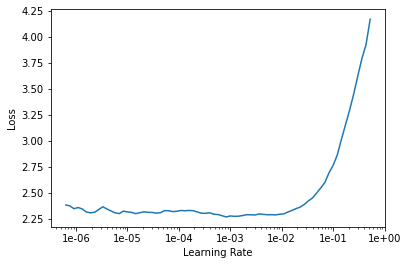

In [20]:
learner.recorder.plot()

In [36]:
learner.freeze_to(-1)
learner.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,time
0,3.314571,2.874032,0.695924,01:43
1,2.832172,2.389335,0.599339,01:50
2,2.294379,2.242158,0.564451,01:50


In [37]:
learner.save('stage-2')

In [25]:
learner.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (10896 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11
Path: ../../data/motoTest;

Valid: LabelList (2723 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
harley-davidson_sportster_2006 - 07,bmw_r-1200-c,honda_nc750x_2014 - 15,kymco_xciting-400i_2012 - 17,kawasaki_z-750_2007 - 14
Path: ../../data/motoTest;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
  

In [38]:
learner.freeze_to(-2)
learner.fit_one_cycle(3, slice(1e-4/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,time
0,2.531312,2.403482,0.629820,01:46
1,2.027666,1.763649,0.473375,01:48
2,1.262709,1.543769,0.415351,01:50


In [39]:
learner.save('stage-3')

In [40]:
learner.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (10896 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11
Path: ../../data/motoTest;

Valid: LabelList (2723 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
harley-davidson_sportster_2006 - 07,bmw_r-1200-c,honda_nc750x_2014 - 15,kymco_xciting-400i_2012 - 17,kawasaki_z-750_2007 - 14
Path: ../../data/motoTest;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
  

In [41]:
learner.freeze_to(-3)
learner.fit_one_cycle(3, slice(1e-5/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,time
0,1.043713,1.501335,0.399927,01:54
1,0.961370,1.451307,0.388909,01:54
2,0.847574,1.441490,0.387440,01:55


In [42]:
learner.save('stage-4')

In [45]:
learner.load('stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (10896 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11,piaggio_mp3_2010 - 11
Path: ../../data/motoTest;

Valid: LabelList (2723 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
harley-davidson_sportster_2006 - 07,bmw_r-1200-c,honda_nc750x_2014 - 15,kymco_xciting-400i_2012 - 17,kawasaki_z-750_2007 - 14
Path: ../../data/motoTest;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
  

In [46]:
learner.unfreeze()
learner.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,time
0,2.227533,2.570607,0.655527,01:52
1,1.811568,1.631716,0.450606,01:52
2,0.956088,1.329756,0.360632,01:55
